# In this model i train a simple classifier
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://www.kaggle.com/gti-upm/leapgestrecog/version/1

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms, models
from load_dataset import process_img, load_dataset

In [9]:
os.chdir('/Users/joeholt/Documents/College Local/Current/CS 639/proj') 
%matplotlib inline

In [5]:
# get dataset
dataset = load_dataset()
loader = torch.utils.data.DataLoader(dataset, batch_size=100)

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 in channel, 6 new feature detectors, 5 kernel size, 1 stride (meaning output channels are same size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16544, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        #print('in:', x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print('pool1:', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('pool2:', x.shape)
        x = x.view(-1, 16 * 22 * 47)
        #print('x view:', x.shape)
        x = F.relu(self.fc1(x))
        #print('x fc1:', x.shape)
        x = F.relu(self.fc2(x))
        #print('x fc2:', x.shape)
        x = self.fc3(x)
        #print('x fin:', x)
        return x


net = Net()

In [34]:
# loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [36]:
# train
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for Xi, yi in loader:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(Xi)
        
        loss = criterion(outputs, yi)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if idx % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, idx + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 6 1 5 5, but got 3-dimensional input of size [100, 50, 50] instead

In [ ]:
class_labels = {
    'palm': 0,
    'l': 1,
    'fist': 2,
    'fist_moved': 3,
    'thumb': 4,
    'index': 5,
    'ok': 6,
    'palm_moved': 7,
    'c': 8,
    'down': 9
}

In [258]:
# see how it worked
classes = list(class_labels.keys())
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

with torch.no_grad():
    
    batch_size = 50
    for idx in range(0, len(X) - batch_size, batch_size):
        # get data
        inputs = torch.FloatTensor(X[idx: idx + batch_size]).permute(0, 3, 1, 2)
        labels = torch.LongTensor(y[idx: idx + batch_size])
        # run through model
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        # predict
        for idx in range(outputs.shape[0]):
            label = predicted[idx]
            actual = labels[idx]
            if actual == label:
                class_correct[label] += 1
            class_total[label] += 1

In [261]:
class_total

[3345.0, 202.0, 9508.0, 0.0, 517.0, 271.0, 1449.0, 0.0, 1838.0, 2820.0]

In [361]:
print("Accuracy by class:")
for idx, c in enumerate(classes):
    if class_total[idx] != 0:
        print("\t{:<12s}   acc = {:04f}".format(c, class_correct[idx]/class_total[idx]))
    else:
        print("\t{:<12s}   acc = {:04f}".format(c, 0.0))

Accuracy by class:
	palm           acc = 0.457100
	l              acc = 0.896040
	fist           acc = 0.350126
	fist_moved     acc = 0.000000
	thumb          acc = 0.829787
	index          acc = 0.118081
	ok             acc = 0.628019
	palm_moved     acc = 0.000000
	c              acc = 0.459195
	down           acc = 0.471277


In [290]:
def predict(img):
    in_to_model = torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0)
    out = net(in_to_model)
    _, predicted = torch.max(out, 1)
    return labels[predicted]
predict(X[0])

'ok'

down predicted to be down


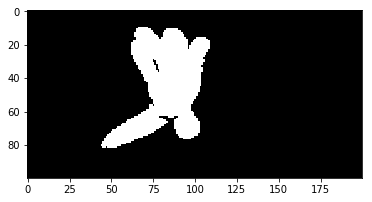

In [343]:
idx = 15000
test = torch.FloatTensor(X[idx]).squeeze()
imshow(test)
print("{} predicted to be {}".format(labels[y[idx]], predict(test.unsqueeze(2))))